## Imports

In [1]:
# File
import pathlib
import pickle

In [2]:
# Data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import skew, skewtest

In [3]:
# Charting
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPool1D, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

## Get Data

In [5]:
X_train = pickle.load(open('./data/X_train.pkl', 'rb'))
X_test = pickle.load(open('./data/X_test.pkl', 'rb'))
y_train = pickle.load(open('./data/y_train.pkl', 'rb'))
y_test = pickle.load(open('./data/y_test.pkl', 'rb'))

In [20]:
del X_train, X_test, y_train, y_test

In [37]:
X_valid = pickle.load(open('./data/X_valid.pkl', 'rb'))
y_valid = pickle.load(open('./data/y_valid.pkl', 'rb'))

## Model

In [5]:
tb_callback = TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True)

In [6]:
class Model():

    def __init__(self):
        self.mdl = None
        self.hist = None

    def create_model(self, input_shape, n_outputs):

        # Optimiser
        opt = Adam(lr=0.001)

        # define model
        self.mdl = Sequential()

        self.mdl.add(Conv2D(9, (2,1), input_shape=input_shape))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())

        self.mdl.add(Flatten())
        self.mdl.add(Dense(500, activation='relu'))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())
        
        self.mdl.add(Dense(n_outputs))

        # Prepare model for training
        self.mdl.compile(loss='mae',
                      optimizer=opt,
                      metrics=['mse'])


    def run_model(self, X_train, X_test, y_train, y_test, callback):

        # Fit model
        self.hist = self.mdl.fit(X_train, y_train,
                                batch_size=1000,
                                epochs=100,
                                verbose=True,
                                validation_data=(X_test, y_test),
                                callbacks=[callback])

In [7]:
# Create Model
model = Model()
model.create_model(X_train[0].shape, y_train.shape[1])

NameError: name 'X_train' is not defined

In [9]:
model.mdl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 2, 9)          27        
_________________________________________________________________
dropout (Dropout)            (None, 99, 2, 9)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 2, 9)          36        
_________________________________________________________________
flatten (Flatten)            (None, 1782)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               891500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2

In [10]:
model.run_model(X_train, X_test, y_train, y_test, tb_callback)

Epoch 1/100
70/70 [==============================] - 6s 75ms/step - loss: 0.5152 - mse: 0.4737 - val_loss: 0.1528 - val_mse: 0.0365
Epoch 2/100
70/70 [==============================] - 5s 68ms/step - loss: 0.1435 - mse: 0.0367 - val_loss: 0.1427 - val_mse: 0.0319
Epoch 3/100
70/70 [==============================] - 5s 68ms/step - loss: 0.0881 - mse: 0.0124 - val_loss: 0.1256 - val_mse: 0.0247
Epoch 4/100
70/70 [==============================] - 5s 71ms/step - loss: 0.0817 - mse: 0.0107 - val_loss: 0.1041 - val_mse: 0.0170
Epoch 5/100
70/70 [==============================] - 5s 74ms/step - loss: 0.0786 - mse: 0.0099 - val_loss: 0.0840 - val_mse: 0.0111
Epoch 6/100
70/70 [==============================] - 5s 70ms/step - loss: 0.0769 - mse: 0.0095 - val_loss: 0.0667 - val_mse: 0.0070
Epoch 7/100
70/70 [==============================] - 5s 72ms/step - loss: 0.0758 - mse: 0.0092 - val_loss: 0.0541 - val_mse: 0.0046
Epoch 8/100
70/70 [==============================] - 5s 75ms/step - loss: 0.

In [13]:
model.mdl.save('./data/cnn-model')

INFO:tensorflow:Assets written to: ./data/cnn-model/assets


In [8]:
model = Model()

In [11]:
model.mdl = load_model('./data/cnn-model')

## Evaluation

In [15]:
# Scores
print(model.mdl.evaluate(X_test, y_test, verbose=0, batch_size=16))

[0.25367048382759094, 0.10326166450977325]


                  0
count  99000.000000
mean      -0.105079
std        0.303679
min       -1.398169
25%       -0.313261
50%       -0.089355
75%        0.094239
max        0.856049


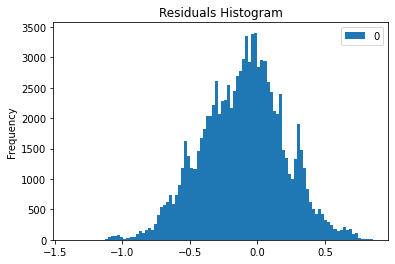

In [17]:
# Error plot (%)
preds = model.mdl.predict(X_test)
resids_all = preds-y_test
resids = pd.DataFrame((preds - y_test).reshape(-1))
resids.plot(kind='hist', bins=100, title='Residuals Histogram')
print(resids.describe())

In [18]:
print(skew(resids)[0])
print(skewtest(resids))

-0.08108935817695238
SkewtestResult(statistic=array([-10.39986098]), pvalue=array([2.48295179e-25]))


In [19]:
comp_ind = 1000
comparison = pd.concat([pd.DataFrame(preds[comp_ind].reshape(-1), columns=['preds']), 
                        pd.DataFrame(y_test[comp_ind].reshape(-1), columns=['true'])], axis=1)
comparison.plot(figsize=(15,10))

IndexError: index 1000 is out of bounds for axis 0 with size 1000

<AxesSubplot:>

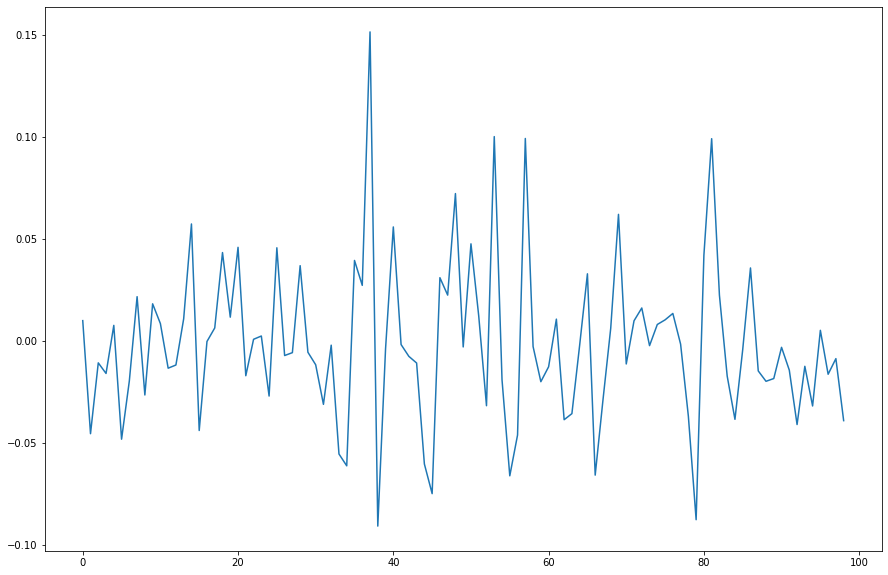

In [18]:
indices = np.random.randint(low=0, high=len(resids_all), size=1)
pd.DataFrame((resids_all[indices])).T.plot(figsize=(15,10), legend=False)

In [19]:
r2_score(y_test, preds)

0.9668898829465232

## Validation

In [20]:
# Scores
print(model.mdl.evaluate(X_valid[:1000], y_valid[:1000], verbose=0, batch_size=1))

[0.25367048382759094, 0.10326166450977325]


                   0
count  990000.000000
mean       -0.105174
std         0.068507
min        -0.582974
25%        -0.134235
50%        -0.096923
75%        -0.066050
max         0.150868


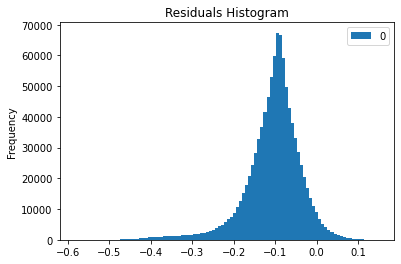

In [38]:
# Error plot (%)
preds = model.mdl.predict(X_valid[:10000], batch_size=1)
resids_all = preds-y_valid[:10000]
resids = pd.DataFrame((preds - y_valid[:10000]).reshape(-1))
resids.plot(kind='hist', bins=100, title='Residuals Histogram')
print(resids.describe())

In [39]:
print(skew(resids)[0])
print(skewtest(resids))

-1.2260148935144384
SkewtestResult(statistic=array([-396.54856291]), pvalue=array([0.]))


<AxesSubplot:>

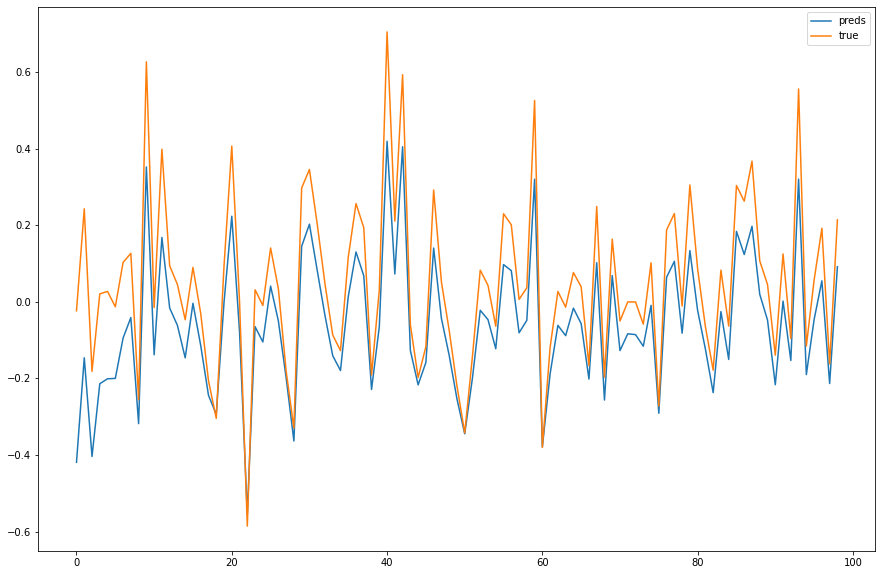

In [40]:
comp_ind = 100
comparison = pd.concat([pd.DataFrame(preds[comp_ind].reshape(-1), columns=['preds']), 
                        pd.DataFrame(y_valid[comp_ind].reshape(-1), columns=['true'])], axis=1)
comparison.plot(figsize=(15,10))

<AxesSubplot:>

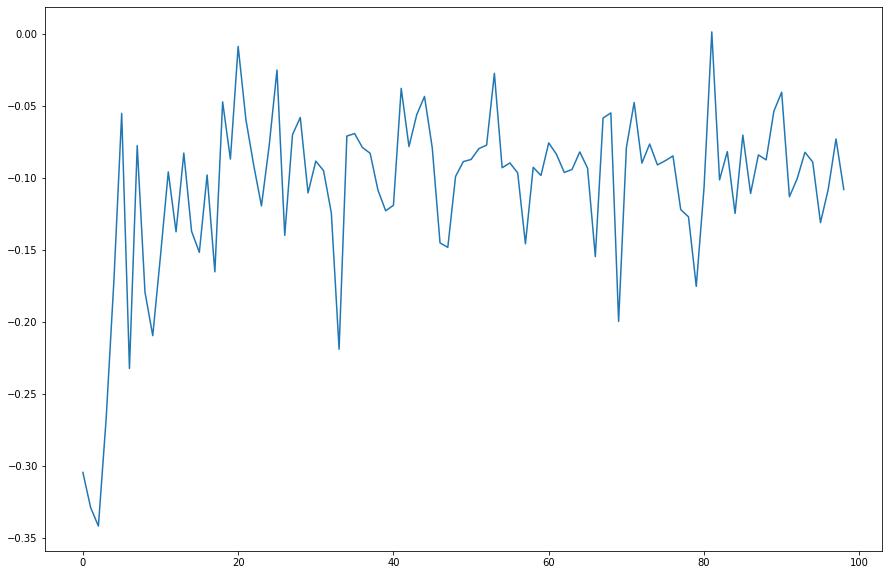

In [41]:
indices = np.random.randint(low=0, high=len(resids_all), size=1)
pd.DataFrame((resids_all[indices])).T.plot(figsize=(15,10), legend=False)

In [42]:
r2_score(y_valid[:10000], preds)

0.686026299563367

## Scaled

In [37]:
disp_raw = np.genfromtxt('./data/disp.csv', delimiter=',')

KeyboardInterrupt: 

In [ ]:
disp_df = pd.DataFrame(disp_raw.T, columns=['disp', 'disp_10noise'])['disp_10noise']

In [ ]:
mean = disp_df.mean()
minimum = disp_df.min()
maximum = disp_df.max()

In [ ]:
scaled_resids = pd.DataFrame(((((resids_all -0.5) * 2.0) * (maximum - minimum)) + mean).reshape(-1))

In [ ]:
scaled_resids.mean()

In [ ]:
scaled_resids.plot(kind='hist', bins=100, figsize=(15,10), title='Errors Histogram for SDOF Problem with 10% Noise')
print('Error Standard Deviation: %E' % scaled_resids.std())
print('Error Mean: %E' % scaled_resids.mean())